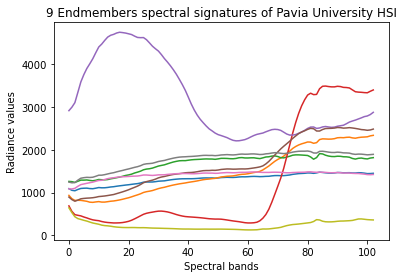

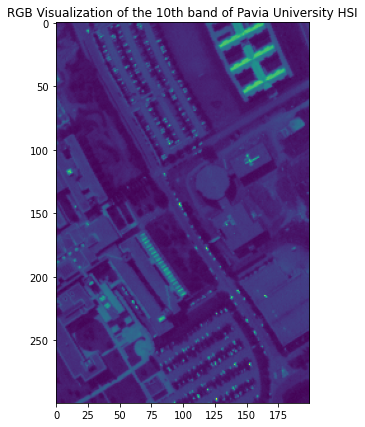

In [1]:
import scipy.io as sio
import numpy as np
from scipy.optimize import nnls, minimize
import matplotlib.pyplot as plt
from sklearn.linear_model import Lasso

Pavia = sio.loadmat('PaviaU_cube.mat')
HSI = Pavia['X'] #Pavia HSI : 300x200x103

ends = sio.loadmat('PaviaU_endmembers.mat') # Endmember's matrix: 103x9
endmembers = ends['endmembers']
fig = plt.figure()
plt.plot(endmembers)
plt.ylabel('Radiance values')
plt.xlabel('Spectral bands')
plt.title('9 Endmembers spectral signatures of Pavia University HSI')
plt.show()

#Perform unmixing for the pixels corresponding to nonzero labels
ground_truth= sio.loadmat('PaviaU_ground_truth.mat')
labels=ground_truth['y']

fig = plt.figure(figsize=(7, 7))
plt.imshow(HSI[:,:,10])
plt.title('RGB Visualization of the 10th band of Pavia University HSI')
plt.show()
# For the non-negative least squares  unmixing algorithm  you can use the nnls function, see the following link:
#https://docs.scipy.org/doc/scipy-0.18.1/reference/generated/scipy.optimize.nnls.html#scipy.optimize.nnls
# ..............
#
#..................

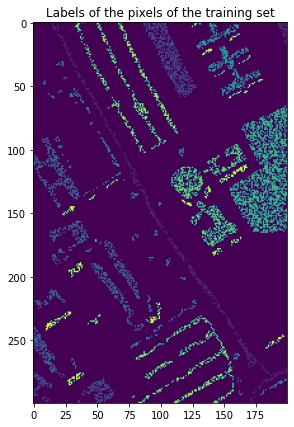

In [2]:
# Trainining set for classification 
Pavia_labels = sio.loadmat('classification_labels_Pavia.mat')
Training_Set = (np.reshape(Pavia_labels['training_set'],(200,300))).T
Test_Set = (np.reshape(Pavia_labels['test_set'],(200,300))).T
Operational_Set = (np.reshape(Pavia_labels['operational_set'],(200,300))).T

fig = plt.figure(figsize=(7, 7))
plt.imshow(Training_Set)
plt.title('Labels of the pixels of the training set')
plt.show()

## Part 1

In [3]:
M, N, L = HSI.shape
m = endmembers.shape[1]

In [4]:
labels_reshaped, HSI_reshaped = labels.flatten(), HSI.reshape((M * N, L))

In [5]:
# Firstly confirm that we have no negative values
assert np.sum(labels_reshaped>=0) == len(labels_reshaped)
# Count the non-zero pixels we are interested in
np.count_nonzero(labels)

12829

In [6]:
X = endmembers
# We compute the below quantity in order to avoid calculating it repeatedly in the following for loop
inverse_XT = np.linalg.inv(X.T @ X) @ X.T
# Utilize Y values to estimate the parameters (thetas) and complete with a 9-dim zero vector where the condition is not met
theta_LS = [inverse_XT @ HSI_reshaped[i] if labels_reshaped[i]!=0 else [0]*m for i in range(M*N)]

In [7]:
theta_LS = np.array(theta_LS)
theta_LS.shape

(60000, 9)

In [8]:
y_ls = X @ theta_LS.T
y_ls.shape

(103, 60000)

### b)

In [9]:
# Define the cost function we want to minimize
def cost_function(theta, X, y):
    return np.linalg.norm(X @ theta - y)**2


In [10]:
constraints = {'type': 'eq', 'fun': lambda x: np.sum(x)-1}
theta_start = np.zeros((1, m))

In [11]:
%%time
# We utilize the minimize function located at the scipy framework and use the constraints defined above
theta_sto = [minimize(cost_function, theta_start, args=(X, HSI_reshaped[i]),
                    constraints=constraints).x if labels_reshaped[i]!=0 else [0]*m for i in range(M*N)]

Wall time: 2min 54s


In [12]:
theta_sto = np.array(theta_sto)
theta_sto.shape

(60000, 9)

In [13]:
y_sto = X @ theta_sto.T

### c)

In [14]:
%%time
# Here, we use the non-negative Least Squares method from the SciPy package
theta_nn = np.array([nnls(X, HSI_reshaped[i])[0] if labels_reshaped[i]!=0 else [0]*m for i in range(M*N)])

theta_nn.shape

Wall time: 830 ms


(60000, 9)

In [15]:
y_nn = X @ theta_nn.T

### d)

In [16]:
%%time
# We work in a way similar to question (b) but we add the bounds kwarg to instill the non-negativity
theta_sto_nn = [minimize(cost_function, theta_start, args=(X, HSI_reshaped[i]), constraints=constraints,
                         bounds=[(0.0, None)] * m).x if labels_reshaped[i] != 0 else [0]*m for i in range(M*N)]

theta_sto_nn = np.array(theta_sto_nn)
theta_sto_nn.shape

Wall time: 35.3 s


(60000, 9)

In [17]:
y_sto_nn = X @ theta_sto_nn.T

### e)

In [18]:
%%time
# We use a large number of iterations in order to give the model the ability to converge
# Moreover, after experimenting with a range of values of `alpha` we ended up using a quite large value which brings
# satisfactory results
theta_lasso = [Lasso(max_iter=1e6, alpha=300, fit_intercept=False).fit(X, HSI_reshaped[i]).coef_ 
                   if labels_reshaped[i] != 0 else [0]*m for i in range(M*N)]

theta_lasso = np.array(theta_lasso)
theta_lasso.shape

Wall time: 1min 56s


(60000, 9)

In [19]:
y_lasso = X @ theta_lasso.T

## A)

In [20]:
def plot_abudance_maps(theta):
    figure = plt.figure(figsize=(14, 14))
    for i in range(m):
        ax = figure.add_subplot(3, 3, i + 1)
        ab_map = theta[:, i].reshape(300, 200)
        ax.imshow(ab_map)
        ax.set_title(f"Abundance map of endmember No{i+1}")


Below we plot the abundance maps for each approach.

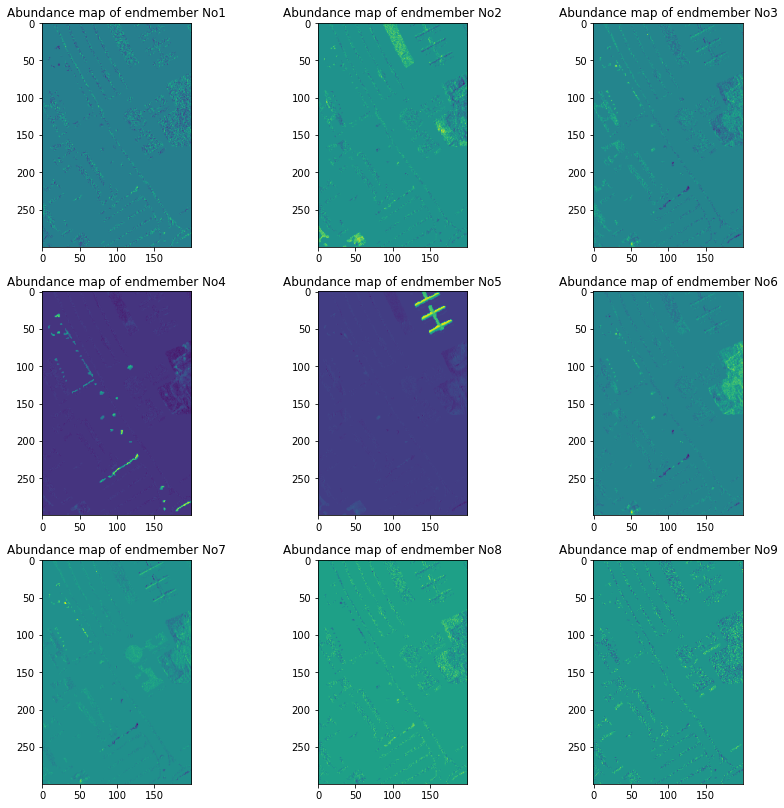

In [21]:
plot_abudance_maps(theta_LS)

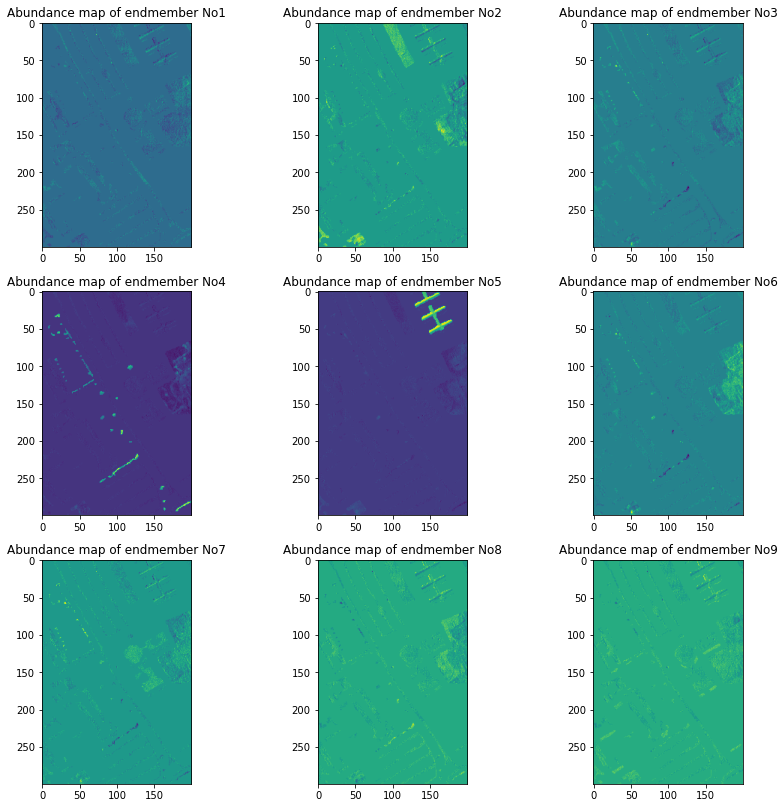

In [22]:
plot_abudance_maps(theta_sto)

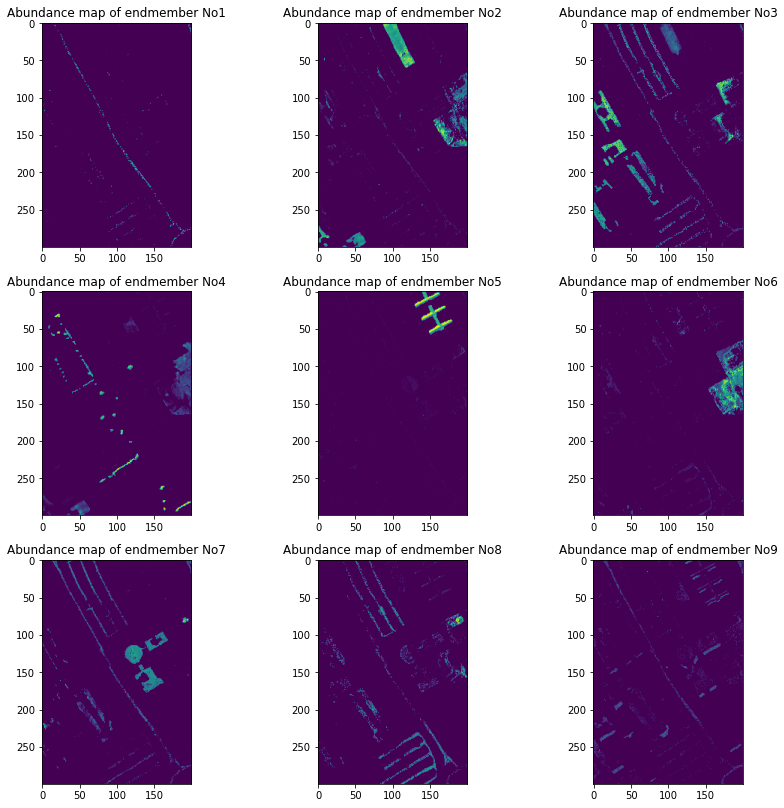

In [23]:
plot_abudance_maps(theta_nn)

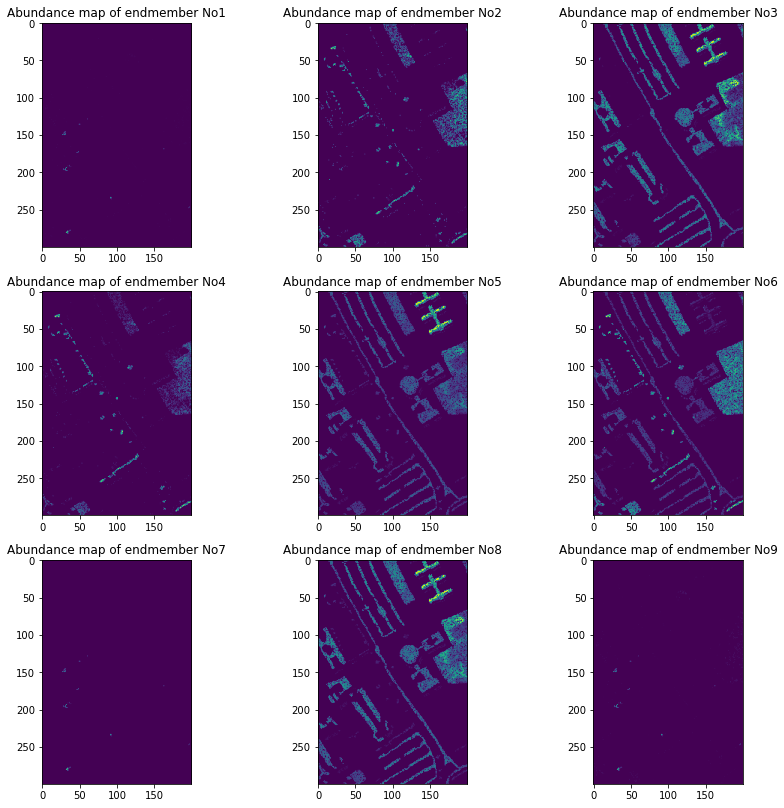

In [24]:
plot_abudance_maps(theta_sto_nn)

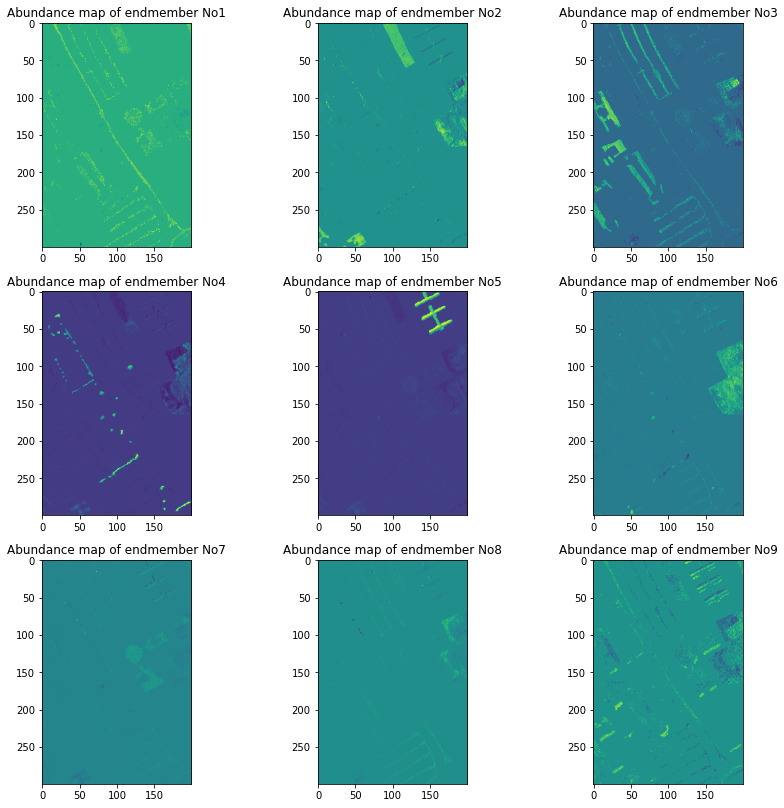

In [25]:
plot_abudance_maps(theta_lasso)

### ii)

In [26]:
def reconstruction_error(y, y_est):
    return np.mean([np.linalg.norm(y[i] - y_est[i])**2 for i in range(M*N) if labels_reshaped[i]!=0])
    

In [27]:
print(f"Reconstruction Error\n\nLeast Squares: {reconstruction_error(HSI_reshaped, y_ls.T):.2f}")
print(f"Least Squares Sum to One: {reconstruction_error(HSI_reshaped, y_sto.T):.2f}")
print(f"Least Squares Non-Negativity: {reconstruction_error(HSI_reshaped, y_nn.T):.2f}")
print(f"Least Squares Non-Negativity Sum to One: {reconstruction_error(HSI_reshaped, y_sto_nn.T):.2f}")
print(f"Lasso: {reconstruction_error(HSI_reshaped, y_lasso.T):.2f}")

Reconstruction Error

Least Squares: 118783.18
Least Squares Sum to One: 160049.93
Least Squares Non-Negativity: 569339.29
Least Squares Non-Negativity Sum to One: 121791987.90
Lasso: 170202.18


## B) 
Fistrly, we plot the ground truth abundance maps, in order to have a qualitative visual comparison at our disposal.

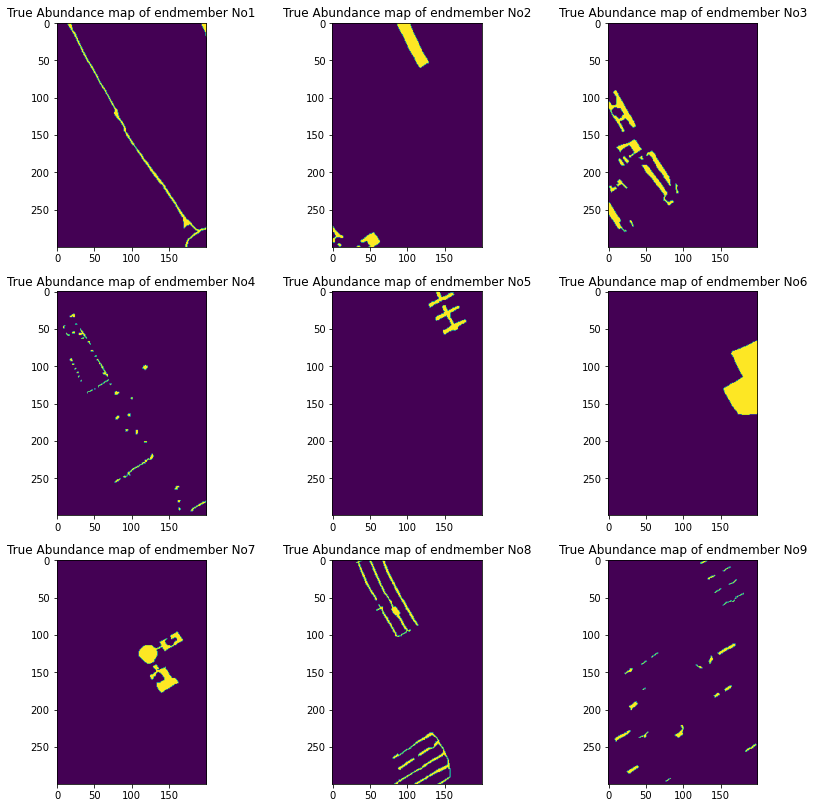

In [28]:
fig = plt.figure(figsize=(14, 14))
for i in range(m):
    ax = fig.add_subplot(3, 3, i + 1)
    ax.imshow((labels == i + 1))
    ax.set_title(f"True Abundance map of endmember No{i+1}")

Looking at the ground truth abundance maps of the endmembers, we infer that the best method is the Least Squares with the non-negativity of the parameters constraint. This comes in contrast with the objective cost function, where this specific method comes in fourth place. Instead, the simple Least Squares seems to perform better followed by the Least Squares with the sum-to-one constraint and the Lasso Regressor. The above observations depict that maybe the reconstruction error is not the most suitable criterion for this specific use case.

## Part 2

In [29]:
Pavia_labels = sio.loadmat('classification_labels_Pavia.mat')
Training_Set = (np.reshape(Pavia_labels['training_set'],(200,300))).T
Test_Set = (np.reshape(Pavia_labels['test_set'],(200,300))).T
Operational_Set = (np.reshape(Pavia_labels['operational_set'],(200,300))).T

In [31]:
X_train, y_train = HSI[Training_Set != 0], Training_Set[Training_Set != 0]
X_test, y_test = HSI[Test_Set != 0], Test_Set[Test_Set != 0]
X_op, y_op = HSI[Operational_Set != 0], Operational_Set[Operational_Set != 0]

In [32]:
X_train.shape, y_train.shape

((6415, 103), (6415,))

In [33]:
X_test.shape, y_test.shape

((3207, 103), (3207,))

In [34]:
assert X_train.shape[0] == np.count_nonzero(Training_Set)

In [35]:
cv_folds = 10

# i) Naive Bayes
### A)
#### i)

In [36]:
from sklearn.metrics import confusion_matrix
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import cross_val_score

clf_nb = GaussianNB()
scores = cross_val_score(clf_nb, X_train, y_train, cv=cv_folds)

In [37]:
def scores_statistics(scores):
    print(f"Mean Error: {(1-scores).mean():.3f}\nStandard Deviation: {(1-scores).std():.3f}")

In [38]:
scores_statistics(scores)

Mean Error: 0.355
Standard Deviation: 0.057


#### ii)

In [39]:
def conf_mat_acc(y_test, y_pred):
    cf = confusion_matrix(y_test, y_pred)
    # We utilize the trace method to sum the diagonal values of the confusion matrix, i.e. the right predictions
    print(f"Confusion matrix:\n\n{cf}\n\nSuccess Rate: {np.trace(cf) / np.sum(cf) * 100 :.2f} %")

In [40]:
clf_nb.fit(X_train, y_train)
y_pred = clf_nb.predict(X_test)
conf_mat_acc(y_test, y_pred)

Confusion matrix:

[[131   0  37   0   0   0  80  13   0]
 [  0 326   4   6   0  17   0   0   0]
 [ 25   2 127   0   0  13  70 299   0]
 [  0   0   0 154   1   1   0   0   0]
 [  0   0   1   0 166   1   0   0   0]
 [  0 312   2  55  32 363   0   0   0]
 [ 18   0  26   0   0   0 277   0   0]
 [  2   1  67   0   0   1   2 388   0]
 [  0   0   0   2   0   0   0   0 185]]

Success Rate: 66.01 %


We additionally examine the performance of the classifier with regard to the `Operational Set`.

In [41]:
conf_mat_acc(y_op, clf_nb.predict(X_op))

Confusion matrix:

[[154   0  46   1   0   0  57  14   0]
 [  0 304   3   6   0  13   0   0   0]
 [ 25   0 127   0   0  13  63 322   0]
 [  0   0   0 154   1   2   0   0   0]
 [  0   0   0   0 171   0   0   0   0]
 [  0 333   5  51  35 342   0   0   0]
 [ 17   0  22   0   0   0 292   0   0]
 [ 10   8  82   0   1   0   5 339   0]
 [  0   0   0   1   0   0   0   0 188]]

Success Rate: 64.58 %


# ii) Minimum Euclidean Distance
### A)
#### i)

In [42]:
from sklearn.model_selection import KFold

errors = []
# We make use of the KFold object in order to make the 10-fold cross-validation split
for val_train, val_test in KFold(n_splits=10).split(X_train, y_train):
    X_train_val, y_train_val = X_train[val_train], y_train[val_train]
    X_test_val, y_test_val = X_train[val_test], y_train[val_test]
    
    # We calculate the mean of every class
    means = [np.mean(X_train_val[y_train_val==i+1], axis=0) for i in range(m)]
    
    y_pred = []
    for i in range(len(X_test_val)):
        # We calculate the Euclidean distance of every test point from each class' mean and take the argmin,
        # in order to take the class with the minimum distance
        distances = [np.linalg.norm(X_test_val[i] - means[j])**2 for j in range(m)]
        y_pred.append(np.argmin(distances) + 1)

    errors_ratio = sum(1 for i in range(len(y_test_val)) if y_test_val[i] != y_pred[i]) / len(y_test_val)
    errors.append(errors_ratio)   


In [43]:
print(f"Mean Error: {np.mean(errors):.3f}\nStandard Deviation: {np.std(errors):.3f}")

Mean Error: 0.465
Standard Deviation: 0.105


#### ii) 
Next, we perform the mean calculation, this time using the whole training dataset and evaluate our model using the test set.

In [44]:
means = [np.mean(X_train[y_train==i+1], axis=0) for i in range(m)]

y_pred = []
for i in range(len(X_test)):
    distances = [np.linalg.norm(X_test[i] - means[j])**2 for j in range(m)]
    y_pred.append(np.argmin(distances) + 1)


In [45]:
conf_mat_acc(y_test, y_pred)

Confusion matrix:

[[152   0  46   0   0   0  61   2   0]
 [  1 188   0   5   0 156   0   3   0]
 [ 66   2 198   0   0   1  39 230   0]
 [  0   0   0 154   0   0   0   0   2]
 [  0   0   0   0 128   0   0  40   0]
 [ 11 317   0  12  16 240   0 168   0]
 [ 61   0  23   0   0   0 237   0   0]
 [  2   1 145   0   0   1   7 305   0]
 [  0   0   0   0   0   0   0   0 187]]

Success Rate: 55.78 %


For the `Operational Set` we get:

In [46]:
y_pred = []
for i in range(len(X_op)):
    distances = [np.linalg.norm(X_op[i] - means[j])**2 for j in range(m)]
    y_pred.append(np.argmin(distances) + 1)


In [47]:
conf_mat_acc(y_op, y_pred)

Confusion matrix:

[[177   0  49   0   0   0  44   2   0]
 [  2 183   0   4   0 135   0   2   0]
 [ 61   0 206   0   0   0  38 245   0]
 [  0   0   0 155   0   1   0   0   1]
 [  0   0   0   0 143   0   0  28   0]
 [  9 339   3   9  14 210   0 182   0]
 [ 62   0  18   0   0   0 251   0   0]
 [  5  11 149   0   0   0  13 267   0]
 [  0   0   0   0   0   0   0   0 189]]

Success Rate: 55.53 %


# iii) k-nn
### A)
#### i)

In [48]:
from sklearn.neighbors import KNeighborsClassifier

# After experimenting with the `n_neighbors` hyperparameter, we ended up using 5 neighbors
# Other values do NOT lead to performance enhancement
clf_knn = KNeighborsClassifier(n_neighbors=5)
scores = cross_val_score(clf_knn, X_train, y_train, cv=cv_folds)

In [49]:
scores_statistics(scores)

Mean Error: 0.152
Standard Deviation: 0.054


#### ii)

In [50]:
clf_knn.fit(X_train, y_train)
y_pred = clf_knn.predict(X_test)
conf_mat_acc(y_test, y_pred)

Confusion matrix:

[[195   0  15   0   0   0  24  27   0]
 [  0 322   0   0   0  31   0   0   0]
 [ 10   1 448   0   0   4   1  72   0]
 [  0   0   0 155   0   1   0   0   0]
 [  0   0   1   0 166   0   0   1   0]
 [  0  56   2   0   1 704   0   1   0]
 [ 12   0   5   0   0   0 303   1   0]
 [  9   2  85   0   0   0   2 363   0]
 [  0   0   0   0   0   0   0   0 187]]

Success Rate: 88.65 %


Perfomance on the `Operational Set`:

In [51]:
conf_mat_acc(y_op, clf_knn.predict(X_op))

Confusion matrix:

[[205   0  25   0   0   0  17  25   0]
 [  0 304   0   0   0  22   0   0   0]
 [ 16   3 451   0   0   1   4  75   0]
 [  0   0   0 155   0   2   0   0   0]
 [  0   0   0   0 171   0   0   0   0]
 [  0  60   0   1   0 704   0   1   0]
 [ 12   0   4   0   0   0 315   0   0]
 [ 16   4  81   0   0   3   4 337   0]
 [  0   0   0   0   0   0   0   0 189]]

Success Rate: 88.28 %


# iv) Bayes Classifier
### A)
#### i)

After searching the internet, i found out that the library `Quadratic Discriminant Analysis` is in fact implementing the Bayes Classifier and provides a quadratic decision boundary.

In [52]:
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

clf_bayes = QuadraticDiscriminantAnalysis()
scores = cross_val_score(clf_bayes, X_train, y_train, cv=cv_folds)

In [53]:
scores_statistics(scores)

Mean Error: 0.144
Standard Deviation: 0.029


#### ii)

In [54]:
clf_bayes.fit(X_train, y_train)
y_pred = clf_bayes.predict(X_test)

conf_mat_acc(y_test, y_pred)

Confusion matrix:

[[155   0  46   0   0   2  10  48   0]
 [  0 328   0   3   0  22   0   0   0]
 [ 10   1 430   0   0   0   0  95   0]
 [  0   0   0 154   0   2   0   0   0]
 [  0   0   0   0 168   0   0   0   0]
 [  0   1   0   1   0 762   0   0   0]
 [ 14   0  10   0   0   2 291   4   0]
 [ 19   0  73   0   0   2   0 367   0]
 [  3   0   0   1   2   0   0   0 181]]

Success Rate: 88.43 %


In [55]:
# Checking also the performance on the Operational Set
conf_mat_acc(y_op, clf_bayes.predict(X_op))

Confusion matrix:

[[165   0  44   0   0   3   6  54   0]
 [  0 314   0   1   0  11   0   0   0]
 [  8   0 461   0   0   0   0  81   0]
 [  0   0   0 156   0   1   0   0   0]
 [  0   0   0   0 171   0   0   0   0]
 [  0   4   0   1   0 761   0   0   0]
 [ 21   0  18   0   0   1 285   6   0]
 [ 20   1  66   0   0  13   0 345   0]
 [  1   0   0   0   3   0   0   0 185]]

Success Rate: 88.65 %


# B)

We can clearly deduce that `k-NN` and `Bayes Classifier` are by far the best candidates for modeling the specific classification problem. This is getting clear looking both the confusion matrix - where (compared with the other methods) there are only a few non diagonal items - and the success rate, which is significantly higher in these models.

# Part 3 

We conclude that the two approaches, i.e. the spectral unmixing (Part 1) and the classification (Part 2) lead to pretty common results. Intuitively, this fact is reasonable, since when a Regressor weighs more a specific feature of the endmembers, in practise it is performing a classification. Furthermore, they seem to present the same problems in discriminating specific classes. In particular, the models seem unconfident when it comes to separating the classes `Asphalt` and `Meadow`. This could be either an inability of our modeling or an inherent weakness of the problem at hand, e.g. maybe the features of these two classes are fairly similar.